<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Multilayer_Perceptron_Market_Timing_in_APPL_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multilayer Perceptron: Market Timing in APPL Stock**

*In this lesson we will start increasing the complexity of our Neural Networks by considering more dense MLPs that incorporate features such as **Dropout** in order to enhance its performance. Also, we will deal here with a **classification** problem. Specifically, we will try to design a strategy that times the return of Apple stock ('AAPL'). For that, we will employ an MLP network that aims to predict whether the future return of AAPL is positive or negative. Based on the predictions from the model, we will later on check how our strategy performs.*

## **1. Data and sources**

As with any other Deep Learning endeavor, the single most important and necessary ingredient is data. Different from what we did in the Momentum timing example, in this case we will retrieve Apple stock price data from Yahoo! Finance using the famous **yfinance** library in Python, which you are already familiar with:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

We will retrieve daily stock price data from AAPL (Apple Inc.) from January 1st, 1980 to a recent date such as April 11th, 2022 (once you have gone through the entire notebook you can check what happens with the model when altering these times).

Once we have daily prices, we can compute daily returns, which will be used to construct the inputs (and output) of our MLP:

In [2]:
df = yf.download("AAPL", start="1980-01-01", end="2022-04-11")

df["Ret"] = df["Adj Close"].pct_change()
df.reset_index(inplace=True)

name = "Ret"  # We define the variable 'name' for simplicity in later use

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Ret
10415,2022-04-04,174.570007,178.490005,174.440002,178.440002,176.423859,76468400,0.023693
10416,2022-04-05,177.500000,178.300003,174.419998,175.059998,173.082047,73401800,-0.018942
10417,2022-04-06,172.360001,173.630005,170.130005,171.830002,169.888580,89058800,-0.018451
10418,2022-04-07,171.160004,173.360001,169.850006,172.139999,170.195053,77594700,0.001804
10419,2022-04-08,171.779999,171.779999,169.199997,170.089996,168.168228,76575500,-0.011909


## **2. Timing Apple stock with Multilayer Perceptron (MLPs)**

As we have already mentioned, the purpose of our MLP is to predict the future return (we will shortly see for which time horizon and how) of AAPL using past returns. Hence, one of the first things we must do is decide and define the inputs and outputs of the model.

### **2.1 Inputs and outputs**

As you already know, there are multiple choices to make when selecting the inputs of a MLP model. Some of them are based on sound theory, but also some simply stem from a trial and error process. In this case, we will apply a very similar approach to what we did when building our models for factor momentum timing and consider as inputs in the network the stock returns from the past 25, 60, 90, 120 and 240 days. Once again, after going over and understanding the entire notebook here, please feel free to play around with these time frames or even add more/less inputs into the MLP to see how its performance changes.

In [3]:
df["Ret25_i"] = df[name].rolling(25).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret60_i"] = df[name].rolling(60).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret90_i"] = df[name].rolling(90).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret120_i"] = df[name].rolling(120).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret240_i"] = df[name].rolling(240).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))

del df["Open"]
del df["Close"]
del df["High"]
del df["Low"]
del df["Volume"]
del df["Adj Close"]

df = df.dropna()
df.tail(10)

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i
10410,2022-03-28,0.005037,0.053177,-0.002813,0.168500,0.239295,0.300388
10411,2022-03-29,0.019134,0.090150,0.019857,0.171149,0.252152,0.322116
10412,2022-03-30,-0.006650,0.109386,-0.011795,0.135913,0.236380,0.310361
10413,2022-03-31,-0.017776,0.074898,-0.016879,0.101120,0.221290,0.305399
10414,2022-04-01,-0.001718,0.060206,0.008005,0.096470,0.220199,0.300737
10415,2022-04-04,0.023693,0.082274,0.048402,0.117761,0.253071,0.336226
10416,2022-04-05,-0.018942,0.074953,0.028462,0.095510,0.238331,0.299128
10417,2022-04-06,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636
10418,2022-04-07,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281901
10419,2022-04-08,-0.011909,0.046183,-0.019567,0.045156,0.170093,0.276003


**Defining the output: Classification**

Finally, we need to define our output label/s. We have decided to focus on the $+120$ (trading) days return for Apple stock. Remember that in this case we will perform a classification task with out MLP model, so that we simply aim to predict whether, on a given time $t$, the return of AAPL from $t$ to $t+120$ days will be positive or negative (note how a zero return, although unlikely, will also be classified as negative).

Therefore, we first investigate, at a given time $t$, what would be the 120-day return on AAPL. Then, we calculate our output variable, keeping in mind that we will be running a classification task and, hence, we need to convert our output variable to a $0, 1$ variable ($0$ for negative 120 days return, $1$ for positive):

In [4]:
df["Ret120"] = df["Ret120_i"].shift(-120)
df["Output"] = df["Ret120"] > 0
df["Output"] = df["Output"].astype(int)
del df["Ret120"]
df = df.dropna()
df.tail(10)

<ipython-input-4-659a9d0c813d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ret120"] = df["Ret120_i"].shift(-120)
<ipython-input-4-659a9d0c813d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Output"] = df["Ret120"] > 0
<ipython-input-4-659a9d0c813d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
10410,2022-03-28,0.005037,0.053177,-0.002813,0.168500,0.239295,0.300388,0
10411,2022-03-29,0.019134,0.090150,0.019857,0.171149,0.252152,0.322116,0
10412,2022-03-30,-0.006650,0.109386,-0.011795,0.135913,0.236380,0.310361,0
10413,2022-03-31,-0.017776,0.074898,-0.016879,0.101120,0.221290,0.305399,0
10414,2022-04-01,-0.001718,0.060206,0.008005,0.096470,0.220199,0.300737,0
10415,2022-04-04,0.023693,0.082274,0.048402,0.117761,0.253071,0.336226,0
10416,2022-04-05,-0.018942,0.074953,0.028462,0.095510,0.238331,0.299128,0
10417,2022-04-06,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636,0
10418,2022-04-07,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281901,0
10419,2022-04-08,-0.011909,0.046183,-0.019567,0.045156,0.170093,0.276003,0


It is always useful to see some summary statistics of the different variables in our model. We can very easily observe them with the '**.describe()**' feature in Python:

In [5]:
df.describe()

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
count,10180,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000
mean,2002-01-24 02:00:56.581532416,0.001180,0.029372,0.070766,0.105697,0.139707,0.275046,0.704322
min,1981-11-24 00:00:00,-0.518692,-0.940299,-1.151643,-1.040123,-1.048317,-0.902590,0.000000
25%,1991-12-17 18:00:00,-0.012825,-0.048530,-0.048529,-0.045875,-0.043797,-0.048385,0.000000
50%,2002-01-22 12:00:00,0.000000,0.035273,0.083604,0.120599,0.159032,0.294689,1.000000
75%,2012-02-29 06:00:00,0.014601,0.115022,0.210867,0.265228,0.315018,0.565962,1.000000
max,2022-04-08 00:00:00,0.332281,0.882472,0.892261,1.141606,1.301160,1.782617,1.000000
std,NaN,0.028192,0.141406,0.226664,0.279427,0.321383,0.447276,0.456369


### **2.2 Train-Test samples and Scaling**

Next important step in building our model is in defining our train and test samples, together with the scaling of variables. As we have usually done before, we will take 20% of observations and devote them to testing, while 80% will be used for training the model. Please note, once again, the importance of doing this in chronological order!

In [6]:
ts = int(0.2 * len(df))  # Number of observations in the test sample
split_time = len(df) - ts  # From this data we are in the test sample
test_time = df.iloc[split_time:, 0:1].values  # Keep the test sample dates
Ret_vector = df.iloc[split_time:, 1:2].values
df.tail()

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
10415,2022-04-04,0.023693,0.082274,0.048402,0.117761,0.253071,0.336226,0
10416,2022-04-05,-0.018942,0.074953,0.028462,0.095510,0.238331,0.299128,0
10417,2022-04-06,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636,0
10418,2022-04-07,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281901,0
10419,2022-04-08,-0.011909,0.046183,-0.019567,0.045156,0.170093,0.276003,0


Now we are ready to use **sklearn** to formally define the input and output matrices for training (**X_train** and **y_train**) and test (**X_test** and **y_test**). One more time, make sure you keep the 'shuffle' option set to 'False'!

In [7]:
from sklearn.model_selection import train_test_split

Xdf, ydf = df.iloc[:, 2:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=False
)  # It is important to keep "shuffle=False"
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8144, 5) (2036, 5) (8144,) (2036,)


The last 'print' in the previous chunk of code gives as an output very useful information specially for a later time where we will move on to more complex models. In this case, we know that we have $8,144$ observations in training for $5$ different input series. Just as a concept check, could you say how many observations are in the test sample?

- **What about scaling?**

As you see, we have not implemented scaling here. Scaling of variables is actually a very good practice that we recommend you always follow. In this case, since we are working with returns from the same stock, the impact that scaling of inputs will have is presumably very limited. (To be clear, we use 'scaled' data by taking prices that adjust for any dividends and stock splits).  Nonetheless, we leave this task to you. Once you have completed the whole notebook, come back here and scale input variables to see whether model performance changes by a lot. Feel free to go back to the last module of Machine Learning, where we introduced scaling.

### **2.3 Model and Training**

Finally, it is time to set up our model. In this case, we will use 3 hidden layers with 25, 15 and 10 units respectively, and a final single-unit output layer. For all the hidden layers, we will use a **ReLU** activation function, whereas we will opt for a **sigmoid** activation in the output layer.

- **Dropout**

Novel to MLP models we have used before (in the Machine Learning course), we are here introducing a **dropout layer** after each of the hidden layers. As you already know, dropout randomly sets some units of a hidden layer to zero. The question of how many units (i.e., frequency rate) is up to the user to define. In this case, we set **n_dropout = 0.2** to shut down 20% of the units in the layer. You can find more info on how the dropout layers work in the official Keras documentation:
https://keras.io/api/layers/regularization_layers/dropout/

- **Loss function?**

So far, we have dealt with regression problems where we used loss functions based on Mean Squared Error (MSE) or Mean Absolute Error (MAE). But now we are in a classification problem with 2 labels (0, 1), so we select a loss function, **binary cross-entropy** that is essentially a log-likelihood:

\
\begin{equation*}
H(y_i) = - \frac{1}{N} \sum_{i=1}^N y_i \ log(p(y_i)) \ + \ (1-y_i) \ log(1-p(y_i))
\end{equation*}

\
For more information on how this loss function works, check the **official documentation** in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

A simple explanation of binary cross-entropy may be found here: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

- **Metric for loss function?**

Still, one question remains about which metric would we use for our loss function based on binary cross-entropy. A **metric** is simply a function that is used to judge the performance of your model. See all metrics available in Keras here: https://keras.io/api/metrics/

Here, we choose to judge our model performance using '**accuracy**', which in this case corresponds to binary accuracy:
https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class

In [10]:
import tensorflow as tf

tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(
    1234
)  # We will set a random seed so that results obtained are somewhat replicable

act_fun = "relu"
hp_units = 25
hp_units_2 = 15
hp_units_3 = 10
n_dropout = 0.2

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

hp_lr = 1e-5  # Learning rate

adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

### **2.3.1 Validation and callbacks (Earlystopping)**

We have already built our model, but there are still a few questions that need an answer when training it: how many epochs do we train for? when does the model stop?

To solve these questions, we will use **EarlyStopping**, a method you are already familiar with (feel free to revisit the documentation for Module 7 of Machine Learning). In this case the variable that we will monitor will be model accuracy in the validation set. Naturally, we will aim to obtain the maximum accuracy in validation, and set the patience to 20, so that model training will stop after 20 epochs in which there is no improvement in the accuracy that the model weights yield in the validation set.

In [11]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

### **2.3.2 Classification on imbalance data: class_weight**

When we work on classification tasks, there is always the possibility that one of the labels we are trying to predict is underrepresented in the training sample. Ideally you would want the model to give a heavier weight to underrepresented labels so that you do not overlook this in future prediction. For example, suppose that you are trying to predict corporate default, but your data has very small percentage of observation when a firm actually defaults. You may want the model to pay more attention to these observations where the actual action occurs. For that, we can use **class_weights**.

**Class-weights** essentially consist on passing Keras a weight for each class in the sample, so that we can make the model focus on a particular class more than it will based on its representation in the sample.

Here you have a complete tutorial on how to perform these kind of tasks that use imbalance data in Keras. Please note that his tutorial covers a wide range of topics that we will eventually cover as well. In order not to get lost in details that are not important for now, we suggest you focus on the 'Class weights' section: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=en


In this case, we would like the model to pay more attention to labels of 0, which correspond to days in which the 120-day-ahead return is negative. There are many ways to assign and modify class weights, we follow here a simple one, completely discretionary:

In [12]:
class_weight = {0: (np.mean(y_train) / 0.5) * 1.2, 1: 1.0}
print(class_weight)

{0: 1.6482318878173827, 1: 1.0}


Finally, we are ready to train our model with all these ingredients!

In [13]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
    class_weight=class_weight,
)

Epoch 1/500
204/204 - 2s - loss: 0.8387 - accuracy: 0.6227 - val_loss: 0.6742 - val_accuracy: 0.7778 - 2s/epoch - 9ms/step
Epoch 2/500
204/204 - 0s - loss: 0.8390 - accuracy: 0.6192 - val_loss: 0.6740 - val_accuracy: 0.7790 - 404ms/epoch - 2ms/step
Epoch 3/500
204/204 - 0s - loss: 0.8374 - accuracy: 0.6249 - val_loss: 0.6738 - val_accuracy: 0.7802 - 395ms/epoch - 2ms/step
Epoch 4/500
204/204 - 0s - loss: 0.8386 - accuracy: 0.6272 - val_loss: 0.6735 - val_accuracy: 0.7815 - 407ms/epoch - 2ms/step
Epoch 5/500
204/204 - 0s - loss: 0.8397 - accuracy: 0.6227 - val_loss: 0.6733 - val_accuracy: 0.7827 - 402ms/epoch - 2ms/step
Epoch 6/500
204/204 - 0s - loss: 0.8386 - accuracy: 0.6309 - val_loss: 0.6730 - val_accuracy: 0.7827 - 401ms/epoch - 2ms/step
Epoch 7/500
204/204 - 0s - loss: 0.8366 - accuracy: 0.6309 - val_loss: 0.6728 - val_accuracy: 0.7833 - 402ms/epoch - 2ms/step
Epoch 8/500
204/204 - 0s - loss: 0.8376 - accuracy: 0.6281 - val_loss: 0.6726 - val_accuracy: 0.7833 - 395ms/epoch - 2ms/

As usual, let's also inspect the summary of the model layers, which in the presence of dropout makes much more sense to have clear in mind:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                150       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                160       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

Note that the presence of the dropout layer does not interfere with the number of parameters in the model. This is because dropout neither adds nor reduces the number of model parameters (or units) as whole, as units are randomly shut down during training epochs, but of course the unit affected is not always the same!

\
This section concludes all relative to the construction and training of the MLP classification model. Now, as we have usually done, let's explore if we could use this model, which achieves a decent accuracy in the validation set, to build a trading strategy:

## **3. Financial performance of the model**

As we have done before, let's now evaluate the use of this model for a financial strategy. It is very important that we clearly understand that evaluating the **financial performance** is a completely separate thing from evaluating the **predictive performance** of the model. Obviously, the two tasks are interrelated, but they may offer completely different conclusions after a thorough analysis. We have already trained our model and assess its fit. Now, we will check if the predictions delivered in the test sample are valid for developing a trading strategy!

### **3.1 Model performance in test sample**
We will start by obtaining the predictions of the model in the test sample and its accuracy. Remember, we are evaluating how well our model predicts, using past AAPL returns for 5 different windows, whether the next 120 days returns is positive or negative. The way we will operate is defining model prediction as a 1 (i.e., positive return) if the probability assigned by the model is higher than 0.5; and 0 (i.e., negative return) else.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc)

64/64 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.7741
Model accuracy in test:  [0.6732466220855713, 0.7740668058395386]


As you can see, we obtain a very decent accuracy of the model in the test sample. But we would also like to see when does the model 'miss', and when it is mostly 'right' about a prediction. For that, we come to our old friend, the confusion matrix:

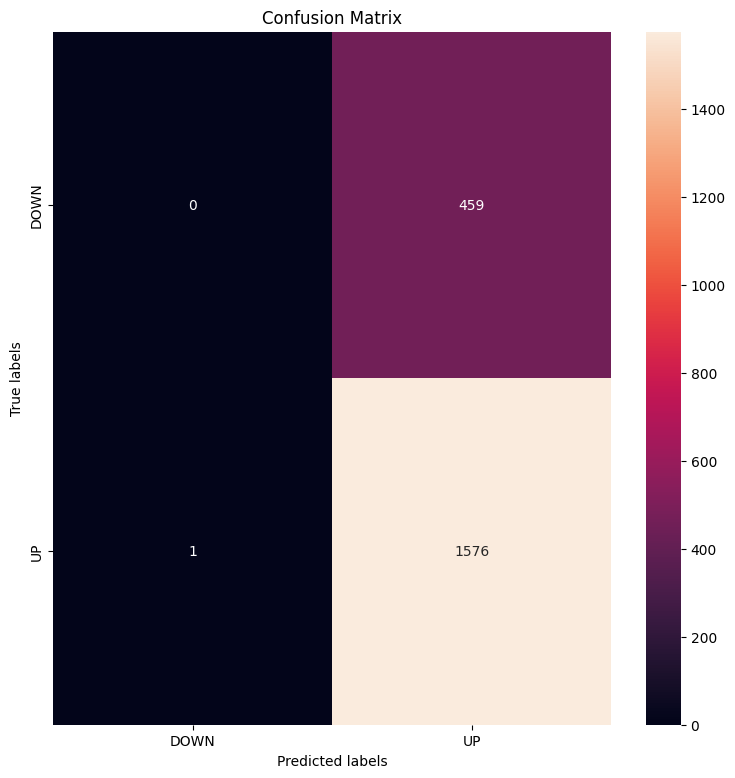

In [16]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
# annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["DOWN", "UP"])
ax.yaxis.set_ticklabels(["DOWN", "UP"]);

### **3.2 Trading strategy based on model predictions**

Next, let's evaluate the extent to which our model predictions can act as the foundation of a trading strategy. To that end, we will perform a **backtest** in the same spirit of Module 7 in Machine Learning:

In [17]:
df_predictions = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred.flatten(),
        "Ret": (Ret_vector.flatten()),
    }
)
df_predictions.tail()

,Date,Pred,Ret
2031,2022-04-04,1,0.023693
2032,2022-04-05,1,-0.018942
2033,2022-04-06,1,-0.018451
2034,2022-04-07,1,0.001804
2035,2022-04-08,1,-0.011909


In [18]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df = df_predictions
df.tail()

,Date,Pred,Ret
2031,2022-04-04,1,0.023693
2032,2022-04-05,1,-0.018942
2033,2022-04-06,1,-0.018451
2034,2022-04-07,1,0.001804
2035,2022-04-08,1,-0.011909


We will define the positions that our trading strategy will take as long ($+1$) if the prediction of the model is higher than $0.5$, and short ($-1$) if less. *(Note, nonetheless, that in practice our prediction can only take values 0 or 1)*

As in previous cases, we will backtest 3 trading strategies:

- A long/short strategy that will take a long or short position when model prediction indicate so.

- A long-only strategy that will go to cash (return = 0) when model predicts a negative 120-day return.

- A Buy-and-hold strategy that will buy the stock at the beginning of the test period and hold it until the end of the period.

In [19]:
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-19-e31b33566a32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions_L"][df["Positions_L"] == -1] = 0


Strat Return Long Only = 901.4372714437698 %
Strat Return = 906.6470481941552 %
Buy and Hold Return = 897.1935624845678 %


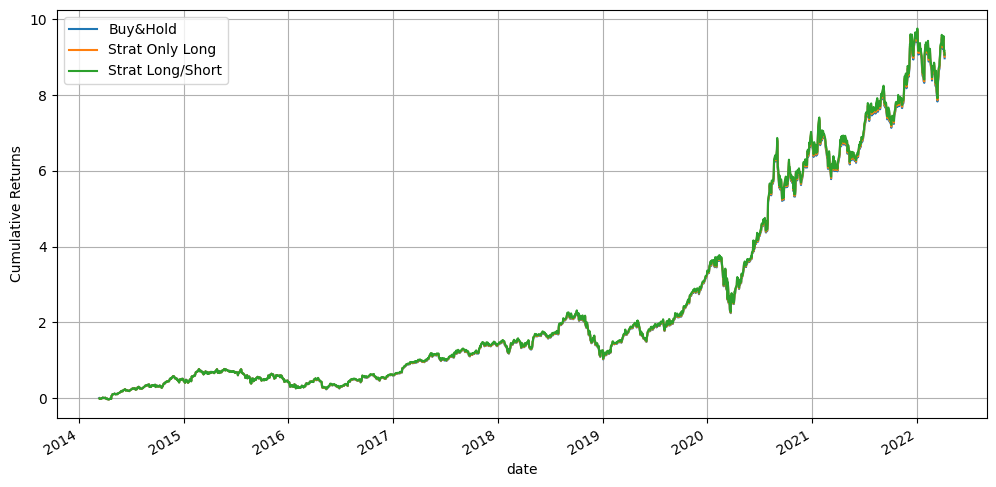

,Date,Pred,Ret,Positions,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet
count,2036,2036.000000,2036.000000,2036.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2036.000000
mean,2018-03-25 23:21:48.447937024,0.999509,0.001289,0.999018,0.001294,0.999509,0.001292,2.526165,2.509804,2.495605
min,2014-03-12 00:00:00,0.000000,-0.128647,-1.000000,-0.128647,0.000000,-0.128647,-0.034755,-0.034755,-0.033819
25%,2016-03-17 18:00:00,1.000000,-0.006615,1.000000,-0.006623,1.000000,-0.006623,0.564414,0.562567,0.558516
50%,2018-03-26 12:00:00,1.000000,0.000921,1.000000,0.000941,1.000000,0.000901,1.440923,1.428290,1.417711
75%,2020-04-02 06:00:00,1.000000,0.010234,1.000000,0.010242,1.000000,0.010242,3.513522,3.490163,3.468611
max,2022-04-08 00:00:00,1.000000,0.119809,1.000000,0.119809,1.000000,0.119809,9.758226,9.702548,9.657195
std,NaN,0.022162,0.017830,0.044324,0.017834,0.022168,0.017834,2.644158,2.629005,2.616331


In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df.describe()

## **4. Conclusion**

In this notebook, we have worked with TensorFlow Keras on a MLP model for classification purposes. Specifically, we designed a MLP model that aims to predict the forward 120 day return of Apple stock. In doing so, we have introduced some novel features of Deep Learning models, such as dropout and class weights, which will also come in handy later on for improving the performance of our models. Still, there is much to be done in terms of improving model performance by, for example, optimally selecting some of the hyperparameters used in the model such as the learning rate.